In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import torch

import dask
import dask.array as da
import re
import glob
import os

from DWR_preprocess import *
import datetime

from tqdm import tqdm
from tqdm.contrib.itertools import product

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings("ignore")

station_number = 26061
window = 5

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, KFold, \
    cross_val_score, RandomizedSearchCV, GridSearchCV, RepeatedKFold, \
    cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, \
                            precision_score, recall_score, confusion_matrix, \
                            ConfusionMatrixDisplay, roc_curve
from sklearn.feature_selection import SelectFromModel

#import imblearn
from collections import Counter
 
window_shape = 5
station_number = 26061

## processing

## Stack analysis

In [24]:
station_number = 26061
array_one_time = np.fromfile(onlyfiles(Paths.data + f'S{station_number}')[0], dtype='ushort')
array_one_time[180:200]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint16)

In [31]:
station_number = 26061

In [55]:
array_one_time = np.fromfile(onlyfiles(Paths.data + f'S{station_number}')[100000], dtype='ushort')
array_one_time[92], onlyfiles(Paths.data + f'S{station_number}')[100000]

(11360,
 '/home/meteofurletov/iram/lightning/data/S26061/G2020/M01/D01/195001.01A')

In [9]:
stack = np.load(Paths.interim + f'stack_{station_number}.npy')
stack.shape

(5401, 200, 200, 19)

In [4]:
phen = stack[:,:,:,12]
phen[phen != 26] = 0
phen[phen == 26] = 1
target = stack[:,:,:,-1]

In [5]:
stack[0,1,1,:]

array([    -100,     -100,     -100,     -100,     -100,     -100,
           -100,     -100,     -100,     -100,     -100,        0,
              0,     4705,      311, 26302050,        1,        1,
              0], dtype=int32)

In [6]:
np.unique(target, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  52,
         53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  66,
         67,  69,  73,  74,  75,  76,  80,  82,  84,  86,  91,  93,  95,
        102, 103, 108, 115, 119, 120, 121, 124, 127, 129, 133, 140, 143,
        146, 148, 149, 154, 159, 162, 172, 173, 175, 184, 186, 190, 219,
        229, 236, 238, 243, 265, 266, 270, 279, 288, 290, 297, 299, 323,
        327, 331, 336, 339, 343, 381, 388, 396, 409, 431, 467, 481, 515,
        606], dtype=int32),
 array([134861615,      9455,      3323,      1666,       951,       667,
              446,       349,       231,       176,       137,       121,
               96,        78,        53,        57,        49,        47,
               36,  

In [ ]:
stack = np.load(Paths.interim + f'stack_{station_number}.npy')
stack = np.delete(stack, (1,2), 0)
phen = stack[0:1155,:,:,12]
phen[phen != 26] = 0
phen[phen == 26] = 1
Y_res = scorer(stack[0:1155,:,:,-1].flatten(), phen.flatten())

In [5]:
scorer(target.flatten(), phen.flatten())

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

### y param flex

In [13]:
phen = stack[:,:,:,12]
phen[phen != 26] = 0
phen[phen == 26] = 1
groz_90 = phen

In [14]:
hmax = stack[:,:,:,11]/4

iso_0 = stack[:,1,1,14]
level_y = np.round(iso_0/1000 + 2).astype('int8')

In [15]:
level_y = np.round(iso_0/1000 + 2).astype('int8')
log_stack = np.zeros((stack.shape[0], stack.shape[1], stack.shape[2]))
for i in range(level_y.shape[0]):
    log_stack[i] = np.log(stack[i,:,:,level_y[i]])
y_param = hmax * log_stack
y_param = np.nan_to_num(y_param,nan=0.0, posinf=0.0, neginf=0.0)

In [17]:
np.unique(y_param)

array([ 0.        ,  1.38629436,  1.55958116, ..., 56.87195712,
       57.29198202, 57.70109593])

In [102]:
pd.DataFrame(y_param.flatten()).describe()

,0
count,6.313227e+06
mean,-inf
std,NaN
min,-inf
25%,0.000000e+00
50%,6.866327e+00
75%,1.388614e+01
max,5.770110e+01


In [90]:
test = np.where(y_param > 18, 1, 0)
np.unique(test, return_counts=True)

(array([0, 1]), array([266466824,    933176]))

In [71]:
np.unique(groz_90, return_counts=True)

(array([0, 1], dtype=int32), array([267276465,    123535]))

In [88]:
np.corrcoef(groz_90.flatten(), test.flatten())

array([[1.        , 0.27973003],
       [0.27973003, 1.        ]])

Accuracy is 0.9996
f1_score is 0.6276
precision_score is 0.6677
recall_score is 0.5921
roc_auc_score is 0.8338
HSS is 0.6275
ETS is 0.4571
CSI is 0.4573
sedi is 0.8972


0    0.999634
1    0.627638
2    0.667730
3    0.592089
4    0.833759
5    0.627456
6    0.457148
7    0.457342
8    0.897228
dtype: float64

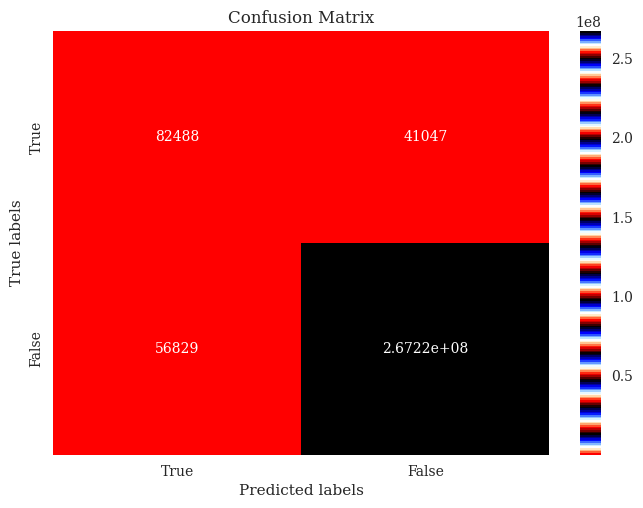

In [52]:
scorer(groz_90.flatten(), test.flatten())

In [15]:
np.all(np.equal(groz_90,test))

False

In [6]:
phen.mean()

0.21654388930441287

In [23]:
(32930+11248+15437+10606+8468)/(34087+12014+16162+11486+9189)

0.9487689599459838

In [24]:
12037/78616

0.15311132593874022

Accuracy is 0.7837
f1_score is 0.0027
precision_score is 0.8672
recall_score is 0.0014
roc_auc_score is 0.8254
HSS is 0.002
ETS is 0.001
CSI is 0.0014
sedi is 0.1933


0    0.783705
1    0.002711
2    0.867219
3    0.001358
4    0.825448
5    0.002036
6    0.001019
7    0.001357
8    0.193294
dtype: float64

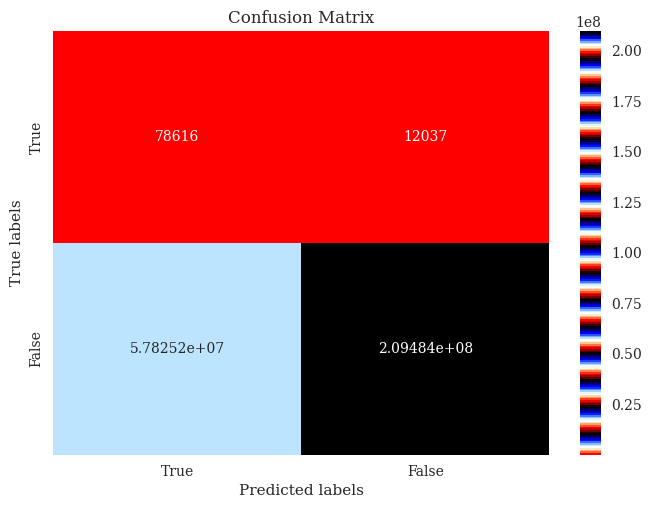

In [8]:
scorer(target.flatten(), phen.flatten())

In [20]:
path = Paths.data + f'S{26850}'
radar_files = onlyfiles(path)
fileName = radar_files[0]
data = np.fromfile(fileName, dtype='ubyte')
latitude = deg2dec(f'''{data[74]}°{data[76]}'{data[78]}"N''')
longitude = deg2dec(f'''{data[82]}°{data[84]}'{data[86]}"N''')
print(f'Latitude is {latitude}, Longitude is {longitude}')
# getting border latitude and longitude of matricies
#  from given lat and long of radar location
latitude_matrix = coords_matrix(latitude, longitude, 200)[0]
longitude_matrix = coords_matrix(latitude, longitude, 200)[1]
# define max and mins of matricies
lat_max = latitude_matrix.max()
lat_min = latitude_matrix.min()
lon_max = longitude_matrix.max()
lon_min = longitude_matrix.min()

Latitude is 53.86583, Longitude is 28.04028


In [21]:
lat_max, lat_min ,lon_max ,lon_min

(55.670556513040786, 52.06110348695922, 31.2187944556146, 24.8617655443854)

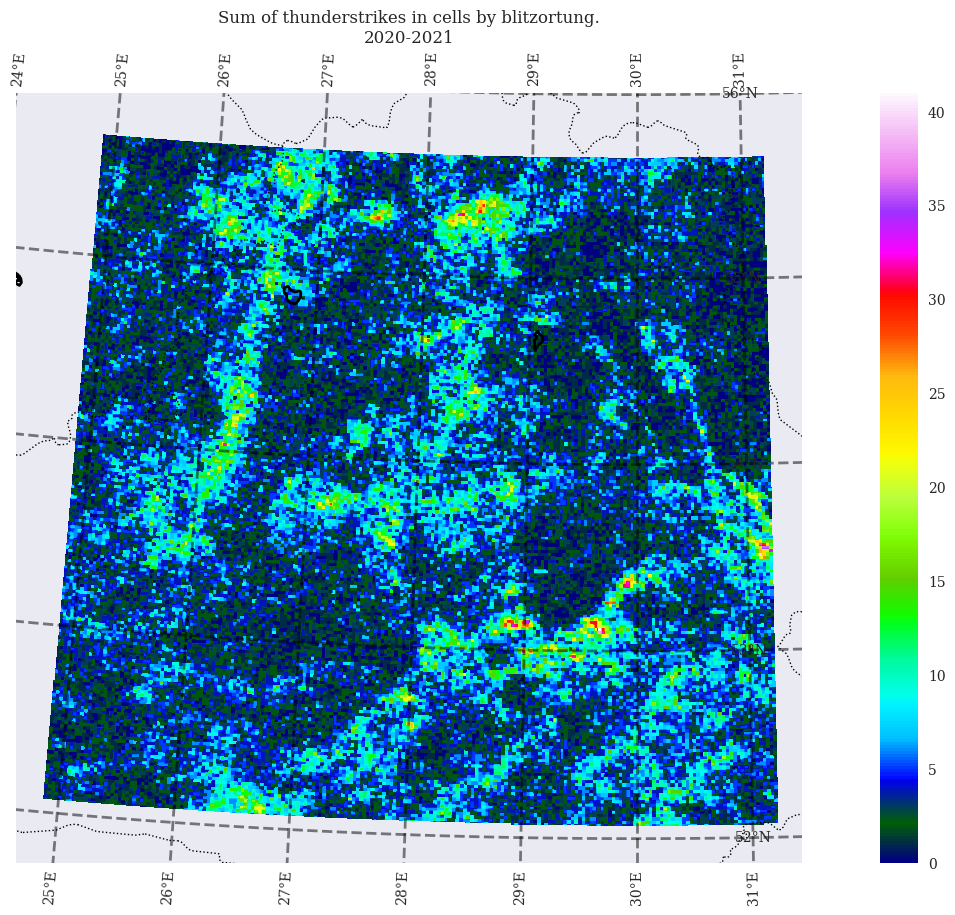

In [13]:
fig = plt.figure(figsize=(20,10))
# get the path of the file. It can be found in the repo data directory
img_extent = (lon_min, lon_max,
              lat_min, lat_max)

ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=30))
plt.title('Sum of thunderstrikes in cells by blitzortung.\n'
          '2020-2021')

ax.use_sticky_edges = False
# set a margin around the data
ax.set_xmargin(0.05)
ax.set_ymargin(0.10)

ax.set_extent([lon_min-0.2, lon_max+0.2,
              lat_min-0.2, lat_max+0.2],
              crs=ccrs.PlateCarree())


ax.add_feature(cfeature.OCEAN,facecolor=("lightblue"))
ax.coastlines(resolution='50m', color='black', linewidth=2)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax.add_feature(cfeature.LAKES, facecolor='None',
               edgecolor='black', linewidth=2)

ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2,
             color='black', alpha=0.5, linestyle='--',
             draw_labels=True)

plt.imshow(np.delete(np.sum(stack[:,:,:,-1], axis = 0),(0,-1),1),
           cmap = 'gist_ncar',
           origin='upper',
           extent=img_extent,
           transform=ccrs.PlateCarree())



plt.colorbar()#shrink = 0.5,aspect = 8)
plt.show()

In [5]:
phen = stack[:,:,:,12]
phen[phen != 26] = 0
phen[phen == 26] = 1

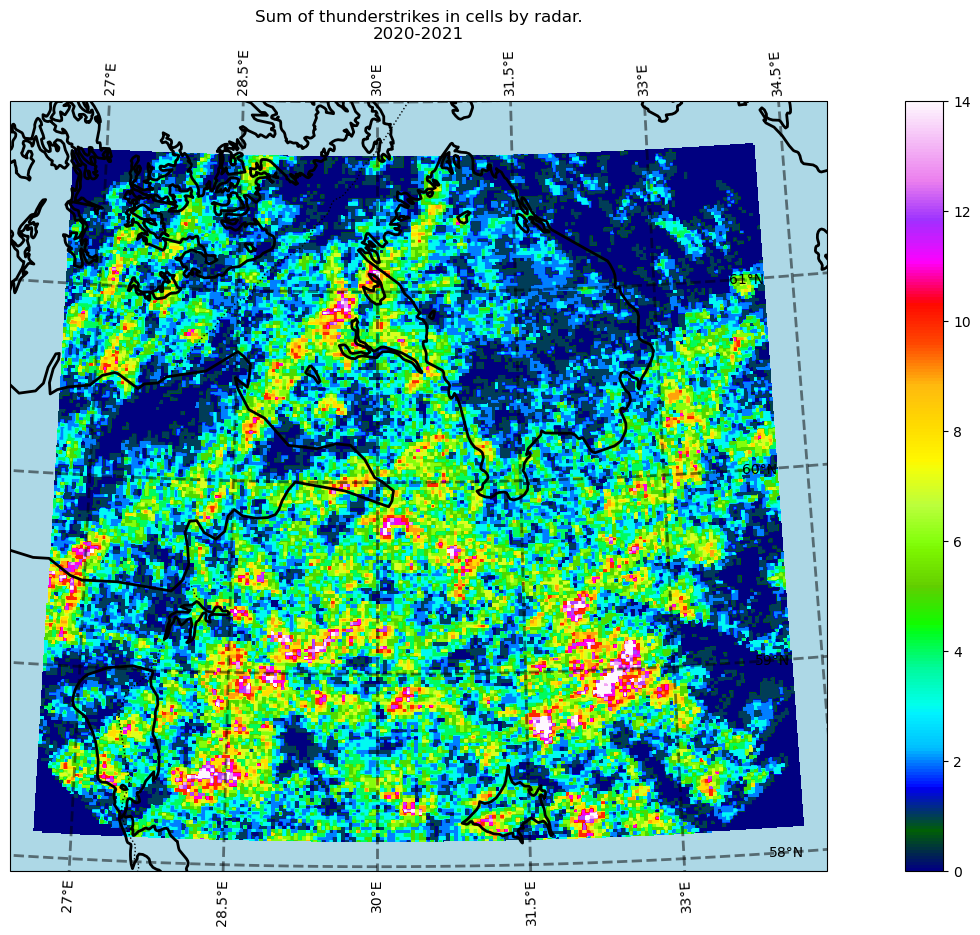

In [6]:
fig = plt.figure(figsize=(20,10))
# get the path of the file. It can be found in the repo data directory
img_extent = (26.625097804781607, 34.19102219521839,
              58.117582381530546, 61.72575761846945)

ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=30))
plt.title('Sum of thunderstrikes in cells by radar.\n'
          '2020-2021')

ax.use_sticky_edges = False
# set a margin around the data
ax.set_xmargin(0.05)
ax.set_ymargin(0.10)

ax.set_extent([26.625097804781607-0.2, 34.19102219521839+0.2,
               58.117582381530546-0.2, 61.72575761846945+0.2],
              crs=ccrs.PlateCarree())


ax.add_feature(cfeature.OCEAN,facecolor=("lightblue"))
ax.coastlines(resolution='50m', color='black', linewidth=2)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
ax.add_feature(cfeature.LAKES, facecolor='None',
               edgecolor='black', linewidth=2)

ax.gridlines(crs=ccrs.PlateCarree(), linewidth=2,
             color='black', alpha=0.5, linestyle='--',
             draw_labels=True)

plt.imshow(np.delete(np.sum(phen, axis = 0),(0,-1),1),
           cmap = 'gist_ncar',
           origin='upper',
           extent=img_extent,
           transform=ccrs.PlateCarree(),
           vmin=0, vmax=14)



plt.colorbar()#shrink = 0.5,aspect = 8)
plt.show()

In [7]:
stack = stack[:,10:190,10:190,:]

In [8]:
phen = stack[:,:,:,12]
phen[phen != 26] = 0
phen[phen == 26] = 1

Accuracy is 0.9993
f1_score is 0.1342
precision_score is 0.1751
recall_score is 0.1087
roc_auc_score is 0.5873
HSS is 0.1338
ETS is 0.0717
CSI is 0.0719
sedi is 0.5807


0    0.999284
1    0.134163
2    0.175113
3    0.108736
4    0.587329
5    0.133825
6    0.071711
7    0.071905
8    0.580652
dtype: float64

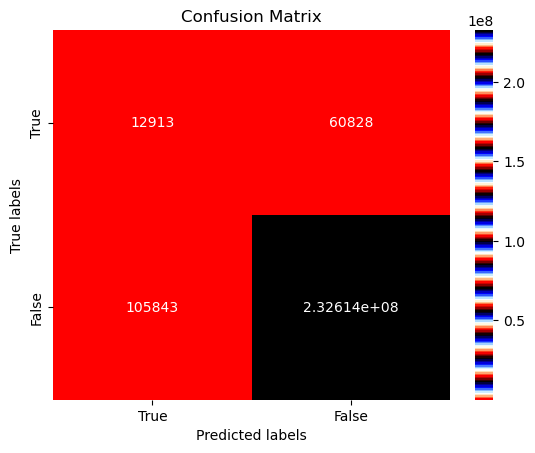

In [6]:
scorer(stack[:,:,:,-1].flatten(), phen.flatten(), 'none', 5)

## Filter analyzis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import torch

import dask
import dask.array as da
import re
import glob
import os

from DWR_preprocess import *
import datetime

from tqdm import tqdm
from tqdm.contrib.itertools import product

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings("ignore")

station_number = 26061
window = 5

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, KFold, \
    cross_val_score, RandomizedSearchCV, GridSearchCV, RepeatedKFold, \
    cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, \
                            precision_score, recall_score, confusion_matrix, \
                            ConfusionMatrixDisplay, roc_curve
from sklearn.feature_selection import SelectFromModel

import imblearn
from collections import Counter
 
window_shape = 5
station_number = 26061

In [2]:
df = pd.read_parquet(Paths.interim + f'{station_number}_Convective_cloud_windows_data.parquet')

(1935422, 318) (483856, 318) (1935422,) (483856,)
Accuracy is 0.9775
f1_score is 0.6089
precision_score is 0.5392
recall_score is 0.6994
roc_auc_score is 0.7657
HSS is 0.5975
ETS is 0.4261
CSI is 0.4377
sedi is 0.8702
CPU times: user 37.5 s, sys: 10.3 s, total: 47.8 s
Wall time: 48 s


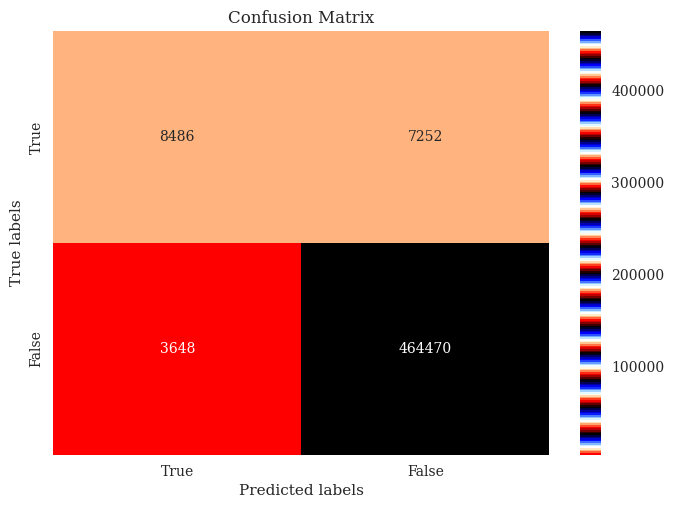

In [3]:
%%time
X = df.loc[:, df.columns != 'target']
y = df.loc[:, 'target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#classificator 
sgd_clf = SGDClassifier(loss="log_loss", n_jobs = -1) 
sgd_clf.fit(X_train, y_train)
sgd_pred = sgd_clf.predict(X_test)

# get scores
sgd_res = scorer(y_test, sgd_pred)

In [4]:
correlations = df.loc[:, df.columns != 'target'].corrwith(df['target'])
corr_sorted = correlations.sort_values(ascending=False)
print(corr_sorted)

rmax_layer_11    0.547177
R(1,3,11)        0.536103
R(1,2,11)        0.535757
R(2,2,11)        0.531629
R(0,3,11)        0.531265
                   ...   
R(4,0,1)         0.071439
R(4,4,1)         0.069929
y_coor           0.038703
x_coor           0.011546
date            -0.028627
Length: 318, dtype: float64


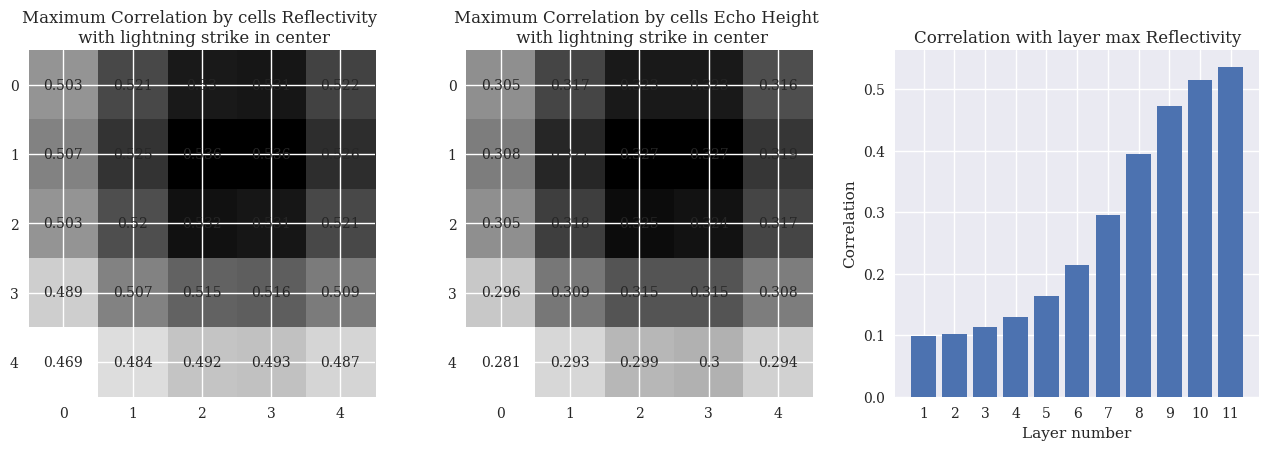

In [5]:
fig, ax = plt.subplots(1, 3, figsize = (16,4.5))

corr_arr = np.array(correlations[:275]).reshape(window_shape,window_shape,11)
data_plot = np.round(np.max(corr_arr, axis = 2),3)

ax[0].imshow(data_plot)
ax[0].set_title("Maximum Correlation by cells Reflectivity \n with lightning strike in center")
for (j,i),label in np.ndenumerate(data_plot):
    ax[0].text(i,j,label,ha='center',va='center')
    
corr_arr_1 = np.array(correlations[275:300]).reshape(5,5)
data_plot_1 = np.round(corr_arr_1,3)

ax[1].imshow(data_plot_1)
ax[1].set_title("Maximum Correlation by cells Echo Height \n with lightning strike in center")
for (j,i),label in np.ndenumerate(data_plot_1):
    ax[1].text(i,j,label,ha='center',va='center')

data_plot = np.max(corr_arr[:,:,:11],axis =(0,1))
ax[2].bar(height = data_plot, x = range(1,12))
ax[2].set_title('Correlation with layer max Reflectivity')
ax[2].set_xlabel('Layer number')
ax[2].set_ylabel('Correlation')
ax[2].set_xticks(range(1, 12))
plt.show()

In [6]:
true_index, = np.where(df.target == 1)
false_index, = np.where(df.target != 1)
print(f'0 - {false_index.shape}, 1 - {true_index.shape}')

0 - (2340589,), 1 - (78689,)


In [7]:
df_true = df.iloc[true_index]
df_false = df.iloc[false_index]

In [8]:
df_filter_rmax = df_true[(df_true['rmax'] < 3.3)]
df_filter_hmax = df_true[(df_true['hmax'] < 4000)]
df_filter_delta = df_true[(df_true['delta_iso22'] < -2000)]

union = np.array(list(set(df_filter_rmax.index) | set(df_filter_hmax.index) | set(df_filter_delta.index)))
df_filtered_1 = df_true.loc[union]
df_filter_1 = df_true.loc[~df_true.index.isin(union)]
df_filtered_1['target'] = df_filtered_1['target'].replace(1,0)
df_false.shape, df_filter_1.shape, df_filtered_1.shape

((2340589, 319), (78284, 319), (405, 319))

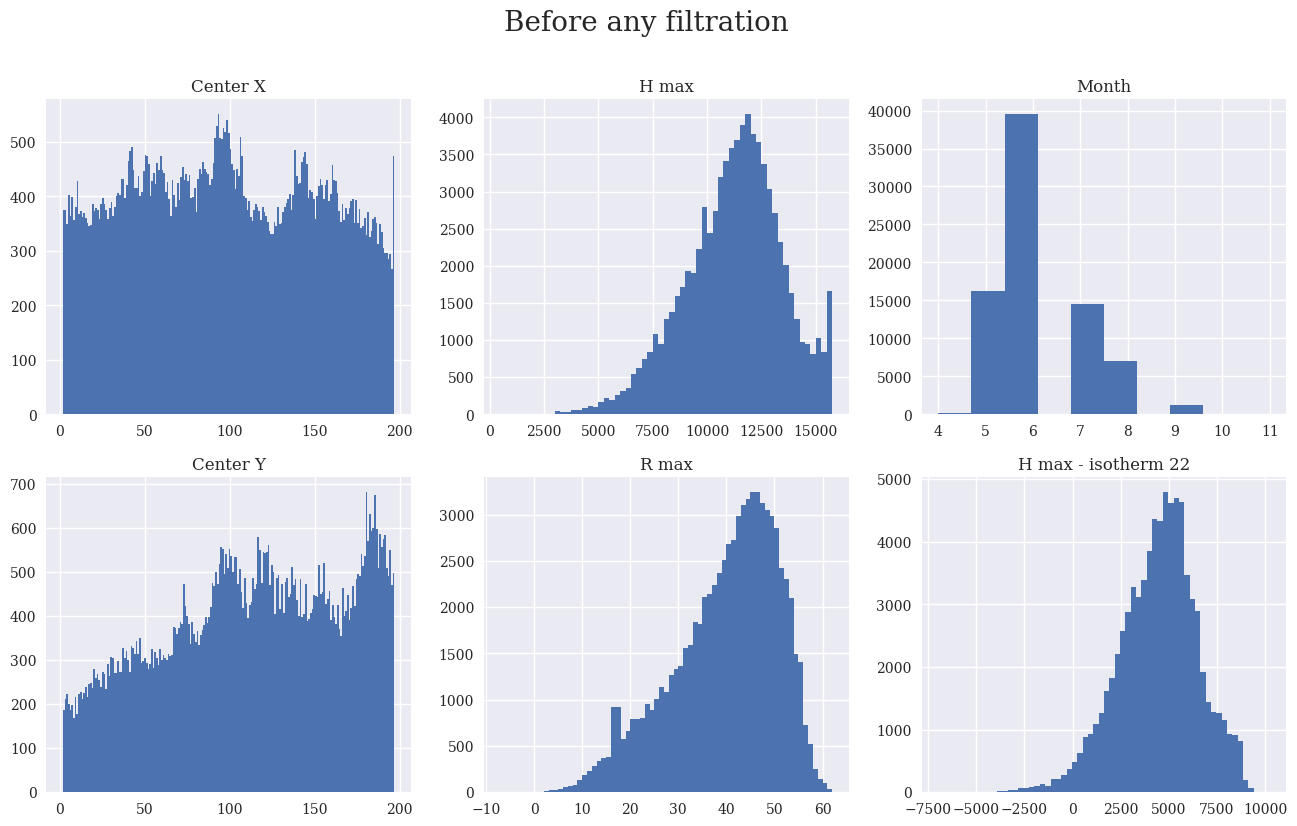

In [9]:
plot_6(df_true, 'Before any filtration')

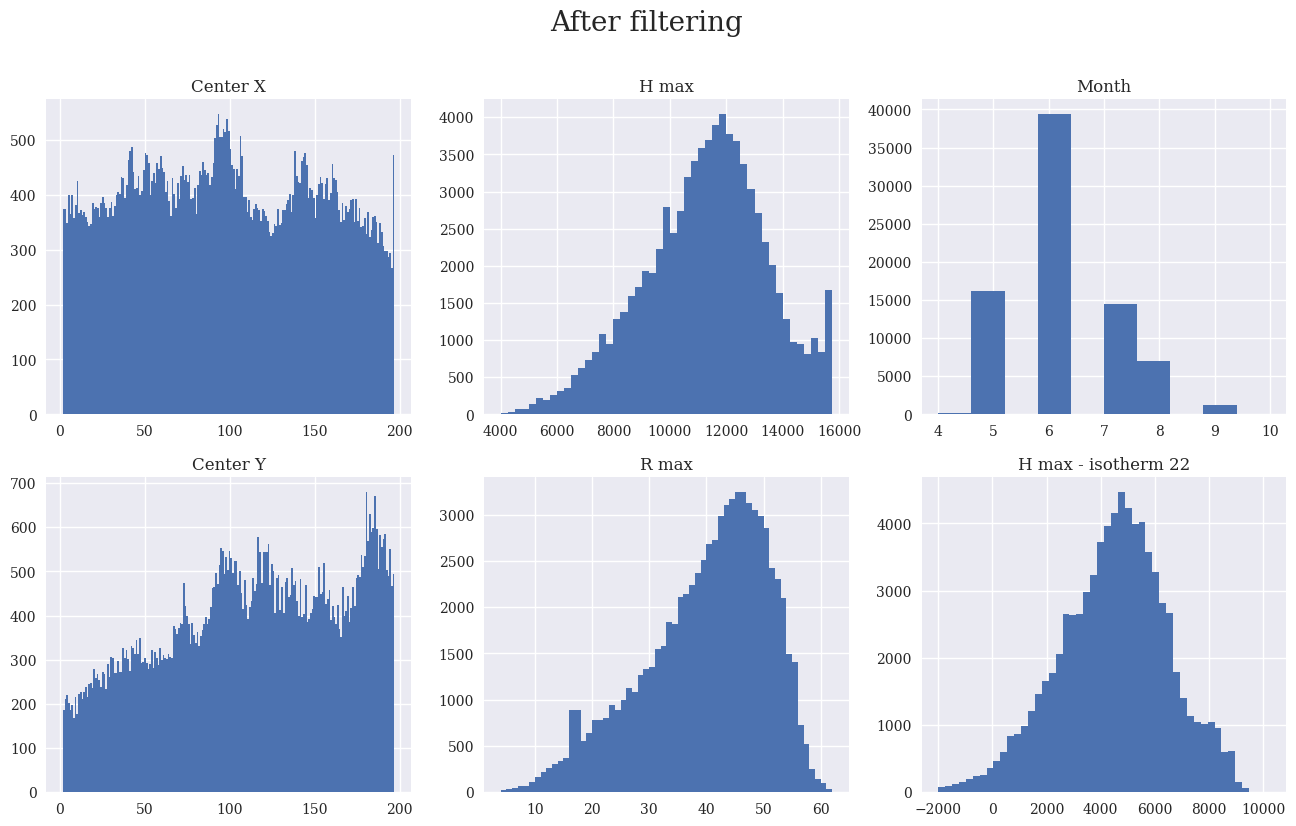

In [10]:
plot_6(df_filter_1, 'After filtering')

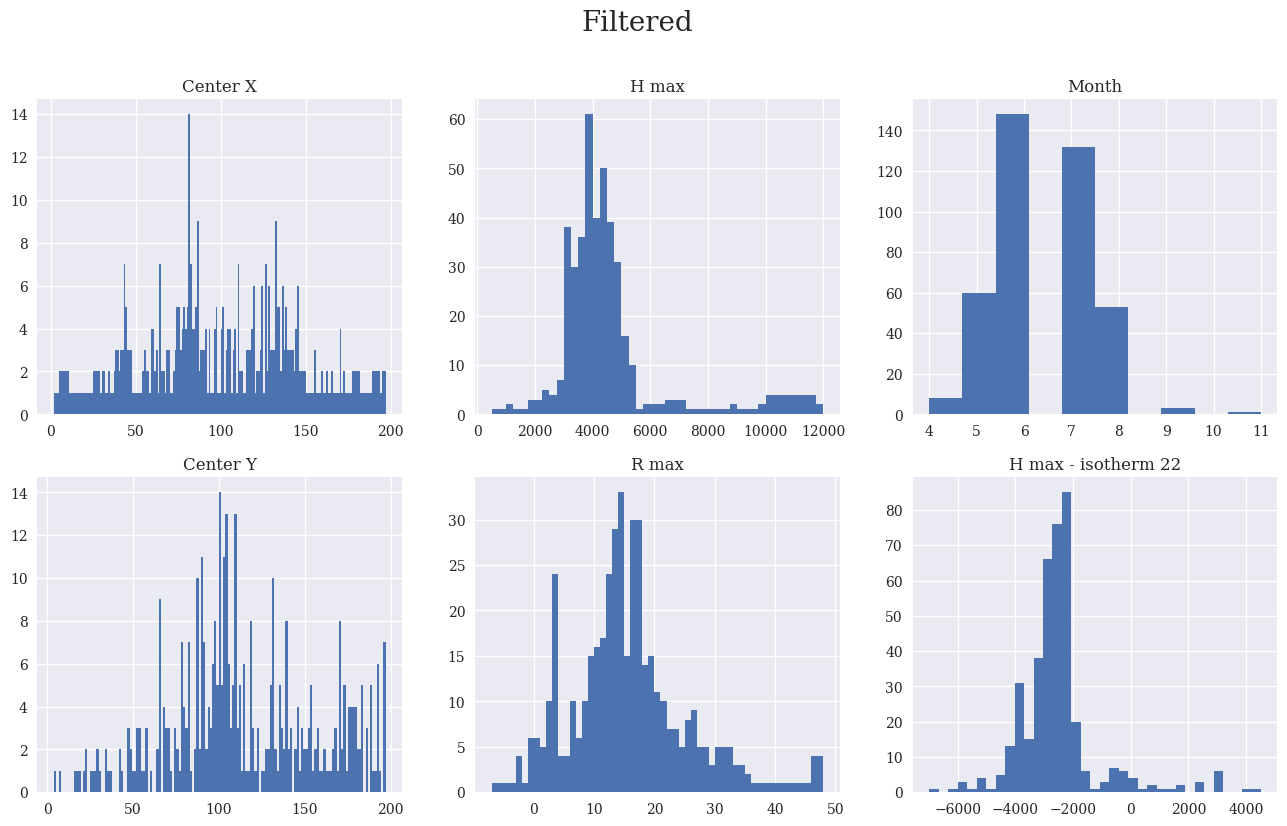

In [11]:
plot_6(df_filtered_1, 'Filtered')

In [12]:
df = pd.concat((df_false, df_filter_1, df_filtered_1))

In [13]:
df_drop = df.drop(df[(df.x_coor > 190) | (df.y_coor > 190) | (df.x_coor < 10) | (df.y_coor < 10)].index)

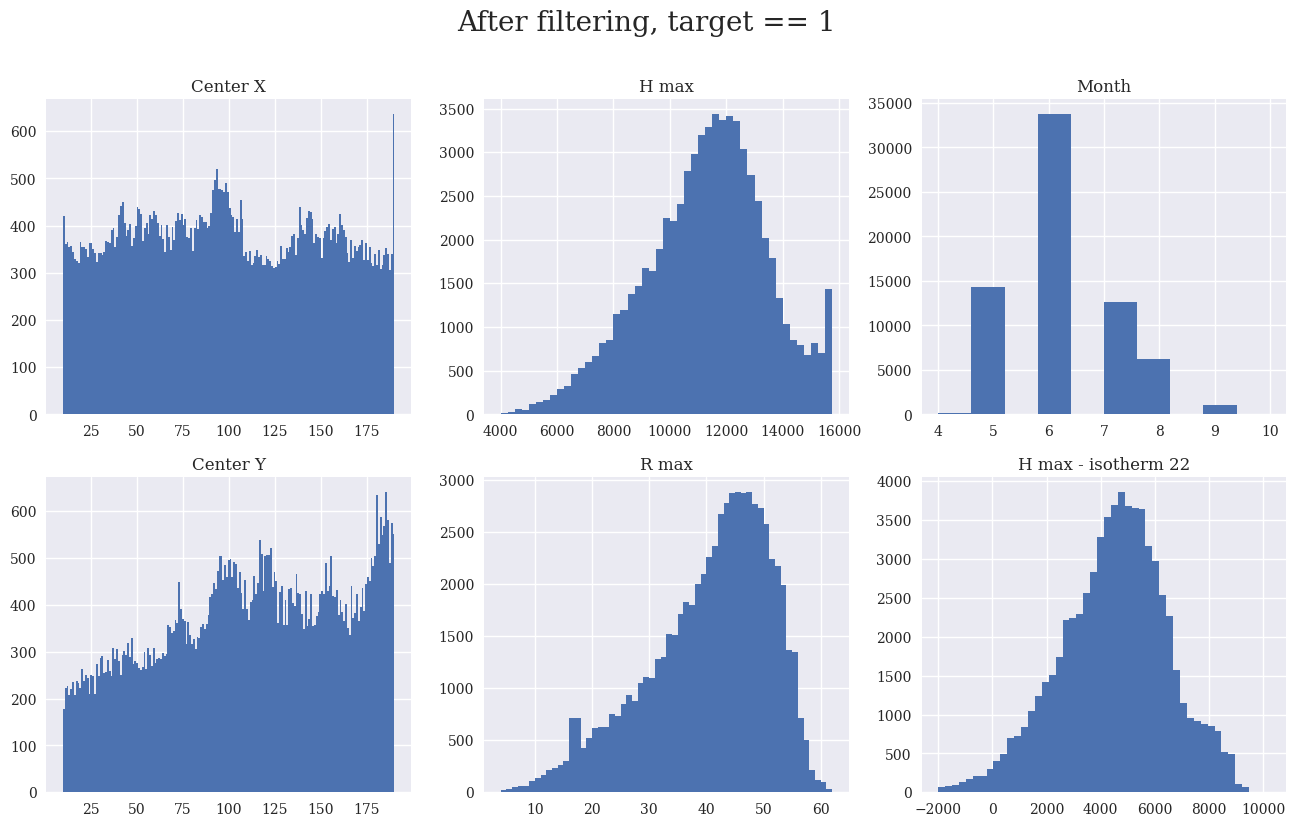

In [14]:
plot_6(df_drop.query('target == 1'), 'After filtering, target == 1')

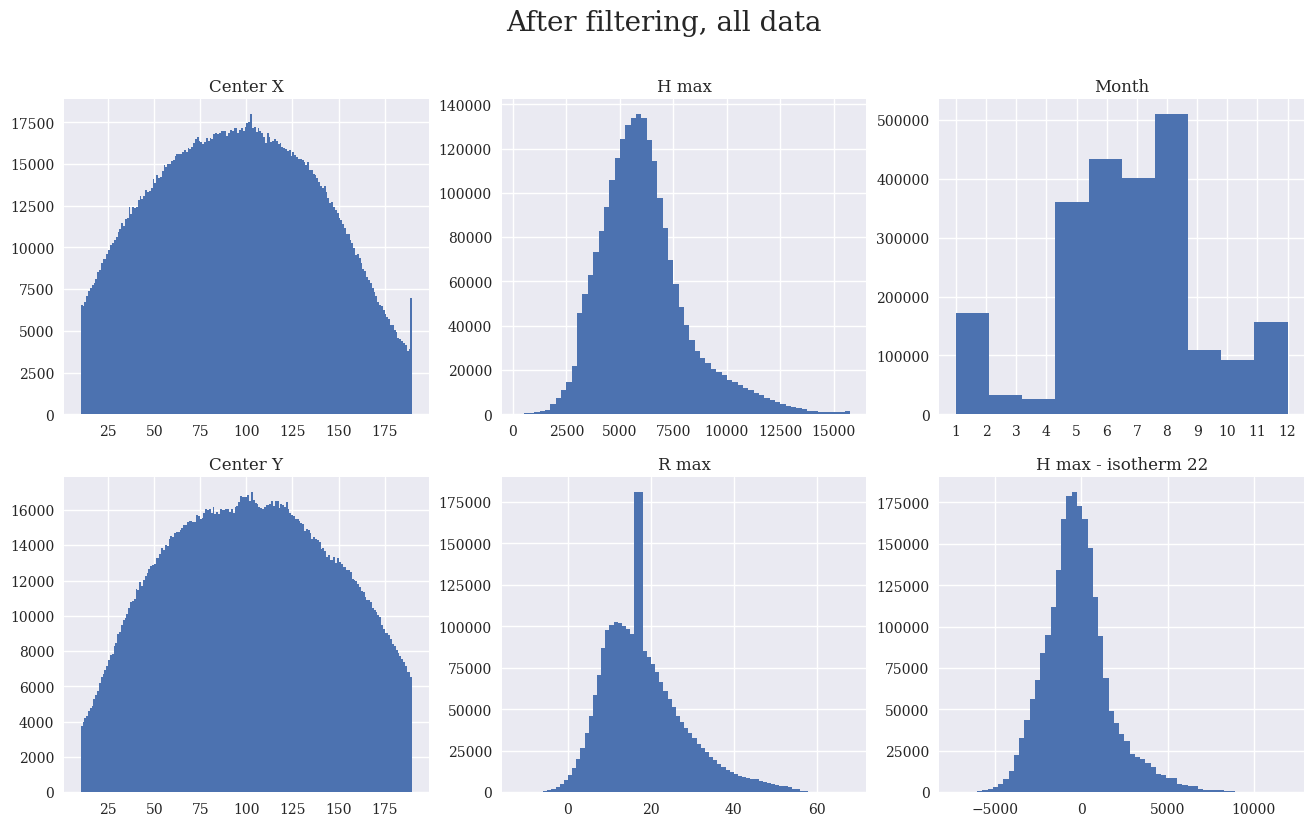

In [15]:
plot_6(df_drop, 'After filtering, all data')

In [20]:
def plot_6_sns(data_to_plot, title):
    """Plot 6 graphs with info about: x_coor, y_coor, H max, Rmax, month
    In seaborn style with difference between true and false"""
    sns.set()
    fig, axes = plt.subplots(2, 3, figsize=(24, 9))
    fig.suptitle(title, fontsize=20)
    for ax in axes.flatten():
        ax.set_yscale('log')

    sns.histplot(ax= axes[0, 0], data = data_to_plot, x='x_coor', hue='target',
                        bins=np.unique(data_to_plot['x_coor']),fill=False)
    #axes[0, 0].set_title('Center X')

    sns.histplot(ax=axes[1, 0], data = data_to_plot, x='y_coor', hue='target', bins=np.unique(
        data_to_plot['y_coor']).shape[0])
    #axes[1, 0].set_title('Center Y')

    sns.histplot(ax=axes[0, 1], data = data_to_plot, x='hmax', hue='target',
                        bins=np.unique(data_to_plot['hmax']))
    #axes[0, 1].set_title('H max')

    sns.histplot(ax=axes[1, 1], data = data_to_plot, x='rmax', hue='target',
                        bins=np.unique(data_to_plot['rmax']))
    #axes[1, 1].set_title('R max')

    sns.histplot(ax=axes[1, 2], data = data_to_plot, x='delta_iso22', hue='target',
                        bins=np.unique(data_to_plot['hmax']).shape[0])
    axes[1, 2].set_title('Month')

    sns.histplot(ax=axes[0, 2], data = data_to_plot, x=pd.DatetimeIndex(
        np.array(data_to_plot['date'], dtype='datetime64[m]')).month, hue='target', shrink=20)
    #axes[0, 2].set_title('Month')

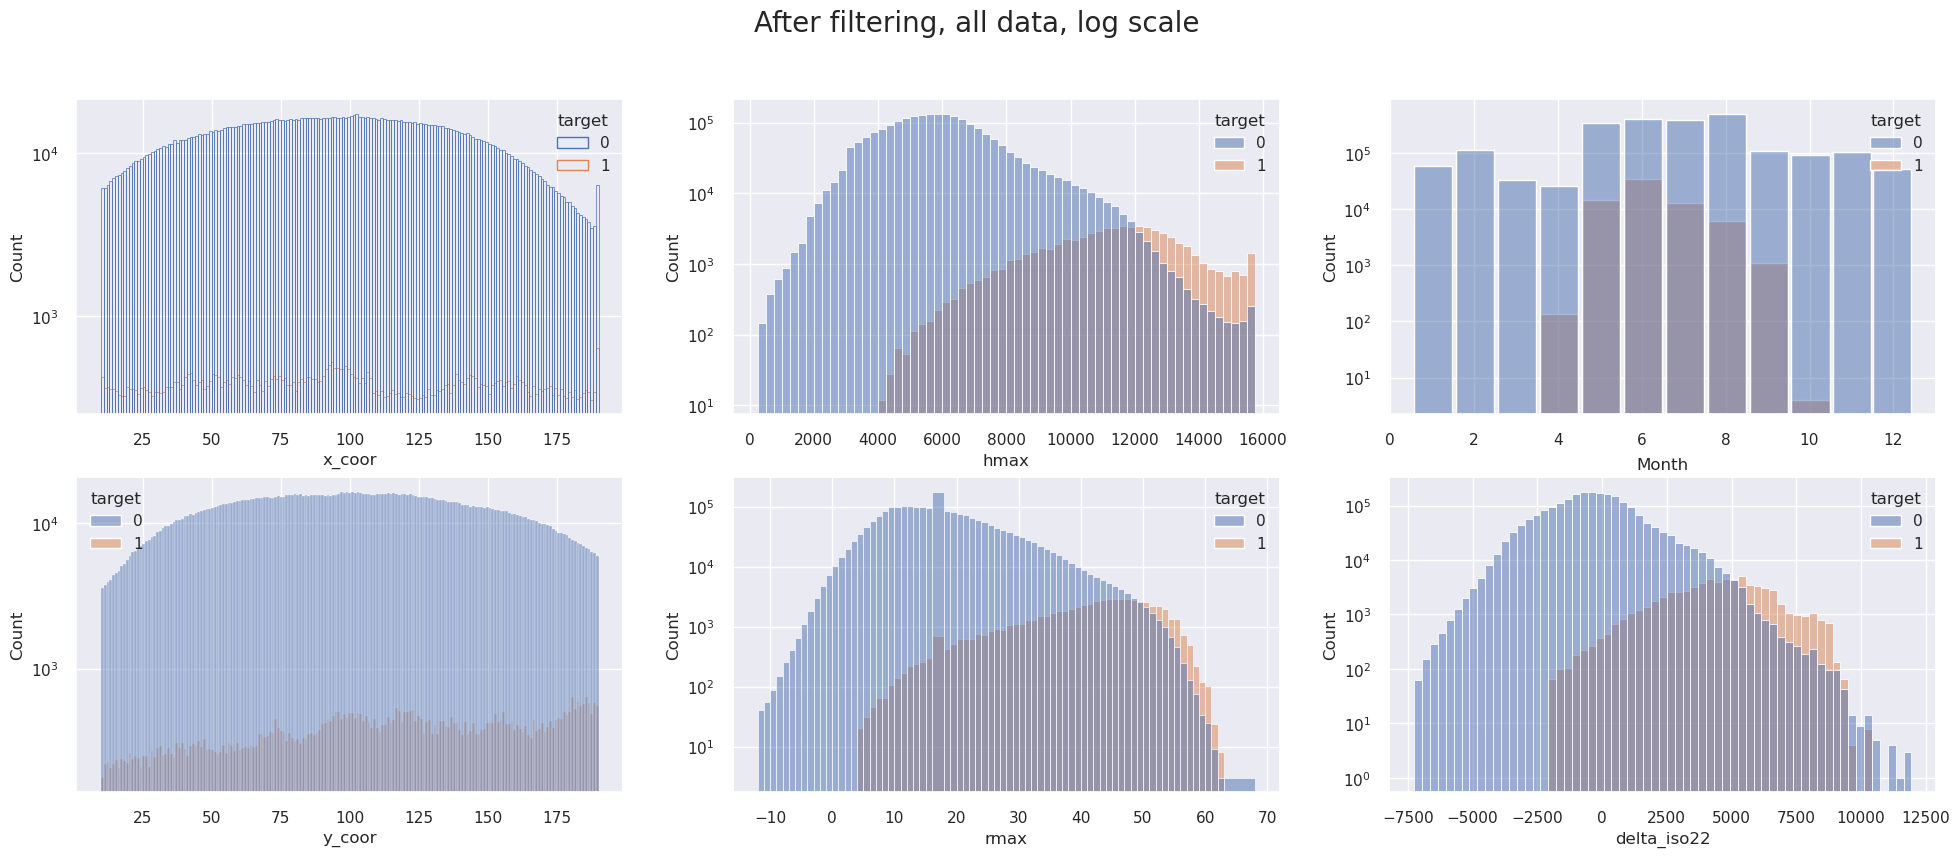

In [21]:
plot_6_sns(df_drop, 'After filtering, all data, log scale')

(1925554, 318) (481389, 318) (1925554,) (481389,)
Accuracy is 0.9789
f1_score is 0.6002
precision_score is 0.5302
recall_score is 0.6915
roc_auc_score is 0.7614
HSS is 0.5895
ETS is 0.418
CSI is 0.4287
sedi is 0.8678
CPU times: user 23.8 s, sys: 2.31 s, total: 26.1 s
Wall time: 26 s


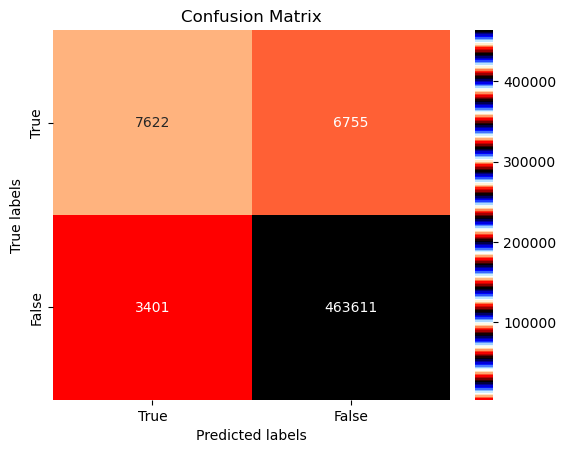

In [13]:
%%time
X = df_drop.loc[:, df_drop.columns != 'target']
y = df_drop.loc[:, 'target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


#classificator 
sgd_clf = SGDClassifier(loss="log_loss", n_jobs = -1) 
sgd_clf.fit(X_train, y_train)
sgd_pred = sgd_clf.predict(X_test)

# get scores
sgd_res = scorer(y_test, sgd_pred, 'sgd', 5)

In [19]:
df_filter = pd.read_parquet(Paths.interim + f'df_filter_{station_number}.parquet')

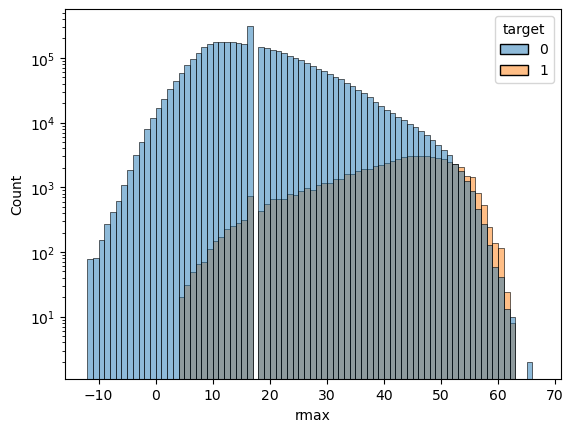

In [33]:
sns.histplot(data = df_filter, x = 'rmax', hue = 'target', bins = np.arange(df_filter.rmax.min(),df_filter.rmax.max()))
plt.yscale('log')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import torch

import dask
import dask.array as da
import re
import glob
import os

from DWR_preprocess import *
import datetime

from tqdm import tqdm
from tqdm.contrib.itertools import product

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings("ignore")

station_number = 26061
window = 5

import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, KFold, \
    cross_val_score, RandomizedSearchCV, GridSearchCV, RepeatedKFold, \
    cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, \
                            precision_score, recall_score, confusion_matrix, \
                            ConfusionMatrixDisplay, roc_curve
from sklearn.feature_selection import SelectFromModel

import imblearn
from collections import Counter
 
window_shape = 5
station_number = 26061

In [27]:
df = pd.read_parquet(Paths.interim + f"selected_df_{station_number}.parquet")

<AxesSubplot: >

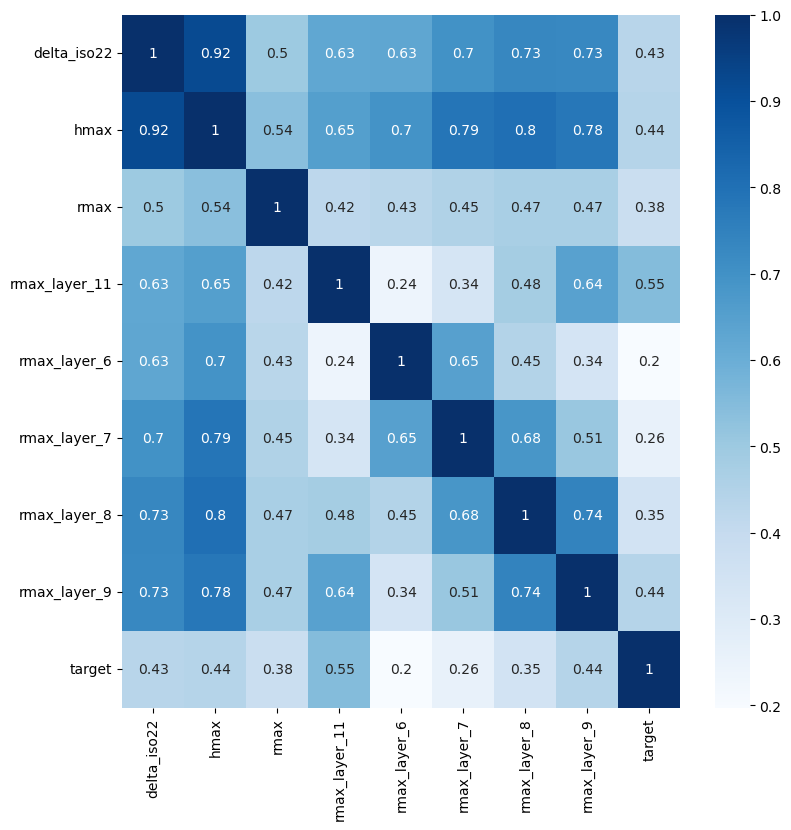

In [28]:
corr = df.corr()
plt.figure(figsize=(9,9))
sns.heatmap(corr, cmap="Blues", annot=True)

In [29]:
X = df.loc[:, df.columns != 'target']
y = df.loc[:, 'target']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1935422, 8) (483856, 8) (1935422,) (483856,)


In [49]:
scaler = StandardScaler().fit(X)
x_scaled = scaler.transform(X)


Accuracy is 0.977
f1_score is 0.5674
precision_score is 0.4659
recall_score is 0.7256
roc_auc_score is 0.73
HSS is 0.5562
ETS is 0.3852
CSI is 0.3961
sedi is 0.8805
CPU times: user 3.31 s, sys: 16 ms, total: 3.33 s
Wall time: 3.33 s


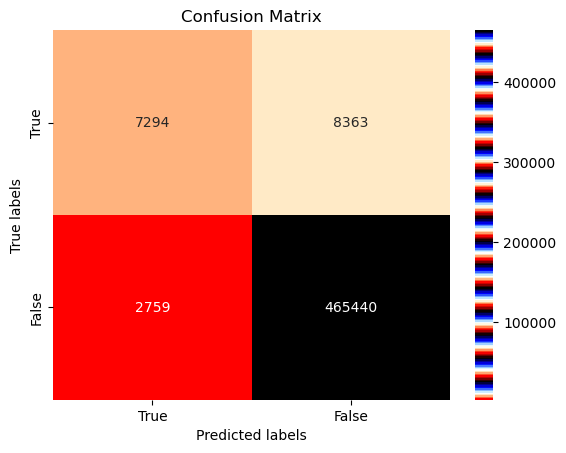

In [46]:
%%time
#classificator 
sgd_clf = SGDClassifier(loss="log", n_jobs = -1) 
sgd_clf.fit(X_train, y_train)
sgd_pred = sgd_clf.predict(X_test)

# get scores
sgd_res = scorer(y_test, sgd_pred)

In [13]:
from imblearn import under_sampling

Resampled dataset shape Counter({0: 1865068, 1: 62627})
Accuracy is 0.9768
f1_score is 0.5838
precision_score is 0.5023
recall_score is 0.6968
roc_auc_score is 0.7475
HSS is 0.5722
ETS is 0.4007
CSI is 0.4122
sedi is 0.8668
CPU times: user 18min 12s, sys: 2.58 s, total: 18min 14s
Wall time: 1min 58s


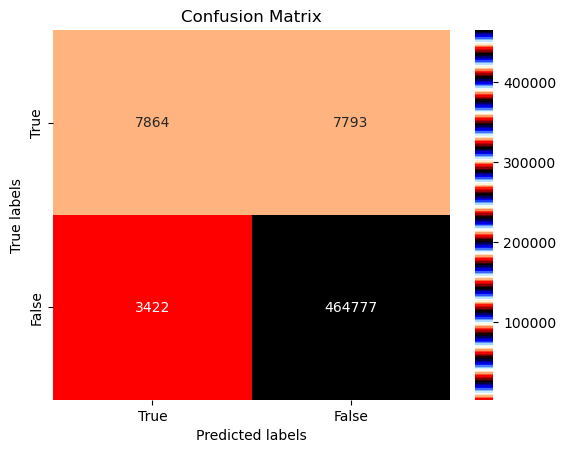

In [14]:
%%time
algorithm = under_sampling.TomekLinks(n_jobs=-2)
X_resampled, y_resampled = algorithm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_resampled.values.flatten().tolist()))

#classificator 
sgd_clf = SGDClassifier(loss="log", n_jobs = -1) 
sgd_clf.fit(X_resampled, y_resampled)
sgd_pred = sgd_clf.predict(X_test)

# get scores
sgd_res = scorer(y_test, sgd_pred, 'sgd', 5)

Resampled dataset shape Counter({0: 62663, 1: 62627})
Accuracy is 0.3473
f1_score is 0.0899
precision_score is 0.996
recall_score is 0.0471
roc_auc_score is 0.6608
HSS is 0.0299
ETS is 0.0152
CSI is 0.0471
sedi is 0.439
CPU times: user 13.8 s, sys: 87.8 ms, total: 13.9 s
Wall time: 13.9 s


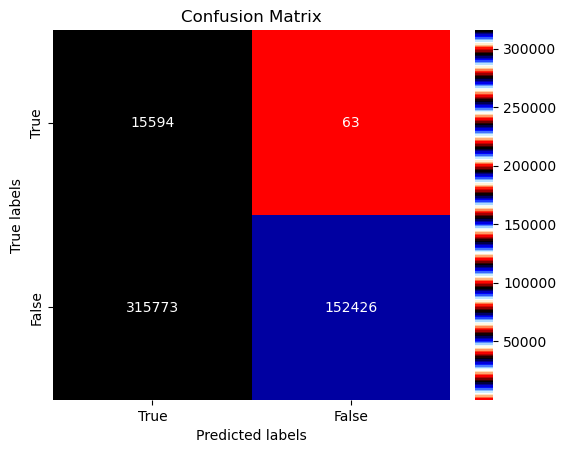

In [15]:
%%time

algorithm = under_sampling.InstanceHardnessThreshold(random_state=42, estimator = SGDClassifier(loss='log', n_jobs = -2))
X_resampled, y_resampled = algorithm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_resampled.values.flatten().tolist()))

#classificator 
sgd_clf = SGDClassifier(loss="log", n_jobs = -1) 
sgd_clf.fit(X_resampled, y_resampled)
sgd_pred = sgd_clf.predict(X_test)

# get scores
sgd_res = scorer(y_test, sgd_pred, 'sgd', 5)

Resampled dataset shape Counter({0: 62627, 1: 62627})
Accuracy is 0.749
f1_score is 0.2
precision_score is 0.97
recall_score is 0.1115
roc_auc_score is 0.8558
HSS is 0.1507
ETS is 0.0815
CSI is 0.1111
sedi is 0.5078
CPU times: user 2min 31s, sys: 364 ms, total: 2min 31s
Wall time: 17.2 s


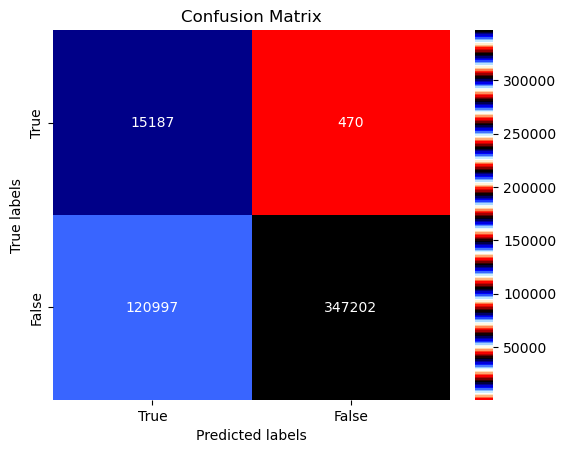

In [16]:
%%time
algorithm = under_sampling.NearMiss(n_jobs=-2)
X_resampled, y_resampled = algorithm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_resampled.values.flatten().tolist()))

#classificator 
sgd_clf = SGDClassifier(loss="log", n_jobs = -1) 
sgd_clf.fit(X_resampled, y_resampled)
sgd_pred = sgd_clf.predict(X_test)

# get scores
sgd_res = scorer(y_test, sgd_pred, 'sgd', 5)

In [19]:
from imblearn import over_sampling

Original dataset shape Counter({0: 1872795, 1: 62627})
Resampled dataset shape Counter({0: 1872795, 1: 1872795})
Accuracy is 0.9073
f1_score is 0.3882
precision_score is 0.9088
recall_score is 0.2468
roc_auc_score is 0.908
HSS is 0.3554
ETS is 0.2161
CSI is 0.2408
sedi is 0.6201
CPU times: user 6.98 s, sys: 63.8 ms, total: 7.04 s
Wall time: 7.05 s


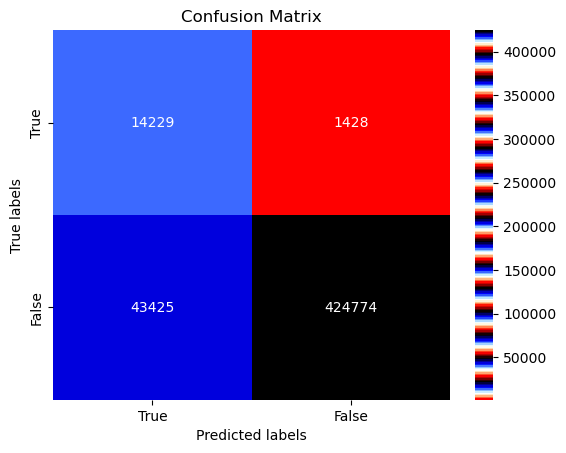

In [21]:
%%time
ros = over_sampling.RandomOverSampler(random_state=0)
print('Original dataset shape %s' % Counter(y_train.values.flatten().tolist()))
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_resampled.values.flatten().tolist()))

#classificator 
sgd_clf = SGDClassifier(loss="log", n_jobs = -1) 
sgd_clf.fit(X_resampled, y_resampled)
sgd_pred = sgd_clf.predict(X_test)

# get scores
sgd_res = scorer(y_test, sgd_pred, 'sgd', 5)

In [36]:
true_index = np.where(y_train == 1)
false_index = np.where(y_train != 1)
print('Original dataset shape %s' % Counter(y_train.values.flatten().tolist()))

X_train_class1 = np.array(X_train)[true_index[0]]
y_train_class1 = np.array(y_train)[true_index[0]]
results = np.array(())
for i in range(11):
    # Oversample the class 1 data points by repeating each element thrice
    X_train_class1_oversampled = X_train_class1.repeat(i, axis = 0)
    y_train_class1_oversampled = y_train_class1.repeat(i, axis = 0)
    
    ## Concatenate the oversampled data tensors with the original data tensors
    X_train_oversampled = np.concatenate([X_train, X_train_class1_oversampled])
    y_train_oversampled = np.concatenate([y_train, y_train_class1_oversampled])
    
    print('Resampled dataset shape %s' % Counter(y_train_oversampled.flatten().tolist()))
    
    #classificator 
    sgd_clf = SGDClassifier(loss="log", n_jobs = -1) 
    sgd_clf.fit(X_train_oversampled, y_train_oversampled)
    sgd_pred = sgd_clf.predict(X_test)
    
    # get scores
    
    sgd_res = scorer(y_test, sgd_pred,verbose=0)
    results = np.hstack((results, sgd_res))

Original dataset shape Counter({0: 1872795, 1: 62627})
Resampled dataset shape Counter({0: 1872795, 1: 62627})
Resampled dataset shape Counter({0: 1872795, 1: 125254})
Resampled dataset shape Counter({0: 1872795, 1: 187881})
Resampled dataset shape Counter({0: 1872795, 1: 250508})
Resampled dataset shape Counter({0: 1872795, 1: 313135})
Resampled dataset shape Counter({0: 1872795, 1: 375762})
Resampled dataset shape Counter({0: 1872795, 1: 438389})
Resampled dataset shape Counter({0: 1872795, 1: 501016})
Resampled dataset shape Counter({0: 1872795, 1: 563643})
Resampled dataset shape Counter({0: 1872795, 1: 626270})
Resampled dataset shape Counter({0: 1872795, 1: 688897})


In [37]:
np.argmax(results[1::9]), results[1::9][np.argmax(results[1::9])]

(2, 0.6241319959641521)

In [38]:
results[1::9]

array([0.57006394, 0.62030173, 0.624132  , 0.60763898, 0.59841157,
       0.5799748 , 0.56653258, 0.54395325, 0.53004397, 0.51812962,
       0.51165666])

Original dataset shape Counter({0: 1872795, 1: 62627})
Resampled dataset shape Counter({0: 1872795, 1: 125254})
Accuracy is 0.9758
f1_score is 0.6214
precision_score is 0.6142
recall_score is 0.6288
roc_auc_score is 0.801
HSS is 0.6089
ETS is 0.4377
CSI is 0.4507
sedi is 0.8361
CPU times: user 3.71 s, sys: 35.9 ms, total: 3.74 s
Wall time: 3.73 s


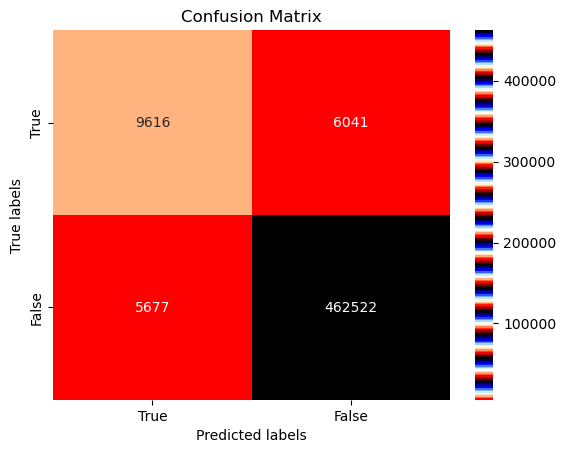

In [41]:
%%time
true_index = np.where(y_train == 1)
false_index = np.where(y_train != 1)
print('Original dataset shape %s' % Counter(y_train.values.flatten().tolist()))

X_train_class1 = np.array(X_train)[true_index[0]]
y_train_class1 = np.array(y_train)[true_index[0]]

# Oversample the class 1 data points by repeating each element thrice
y_train_class1_oversampled = y_train_class1.repeat(1, axis = 0)
X_train_class1_oversampled = X_train_class1.repeat(1, axis = 0)

## Concatenate the oversampled data tensors with the original data tensors
X_train_oversampled = np.concatenate([X_train, X_train_class1_oversampled])
y_train_oversampled = np.concatenate([y_train, y_train_class1_oversampled])

print('Resampled dataset shape %s' % Counter(y_train_oversampled.flatten().tolist()))

#classificator 
sgd_clf = SGDClassifier(loss="log", n_jobs = -1) 
sgd_clf.fit(X_train_oversampled, y_train_oversampled)
sgd_pred = sgd_clf.predict(X_test)

# get scores
sgd_res = scorer(y_test, sgd_pred)

Original dataset shape Counter({0: 1872795, 1: 62627})
Resampled dataset shape Counter({0: 1872795, 1: 1872795})
Accuracy is 0.9059
f1_score is 0.3849
precision_score is 0.9101
recall_score is 0.2441
roc_auc_score is 0.9079
HSS is 0.3518
ETS is 0.2135
CSI is 0.2383
sedi is 0.6182
CPU times: user 8.63 s, sys: 104 ms, total: 8.73 s
Wall time: 8.73 s


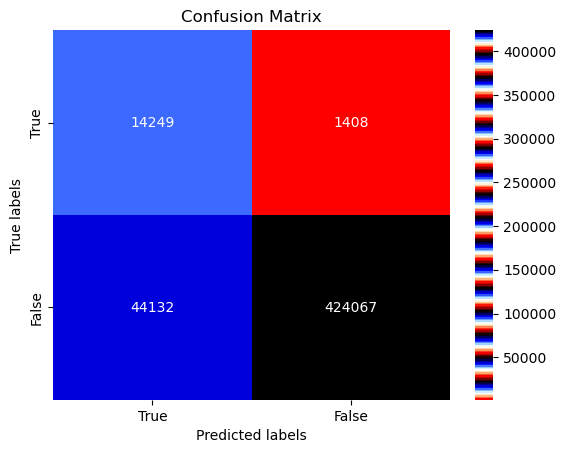

In [28]:
%%time
algo = over_sampling.SMOTE(random_state=0)
print('Original dataset shape %s' % Counter(y_train.values.flatten().tolist()))
X_resampled, y_resampled = algo.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_resampled.values.flatten().tolist()))

#classificator 
sgd_clf = SGDClassifier(loss="log", n_jobs = -1) 
sgd_clf.fit(X_resampled, y_resampled)
sgd_pred = sgd_clf.predict(X_test)

# get scores
sgd_res = scorer(y_test, sgd_pred, 'sgd', 5)

Original dataset shape Counter({0: 1872795, 1: 62627})
Resampled dataset shape Counter({0: 1872795, 1: 1872795})
Accuracy is 0.88
f1_score is 0.3344
precision_score is 0.9317
recall_score is 0.2037
roc_auc_score is 0.9049
HSS is 0.297
ETS is 0.1744
CSI is 0.2007
sedi is 0.5901
CPU times: user 17.7 s, sys: 132 ms, total: 17.8 s
Wall time: 17.8 s


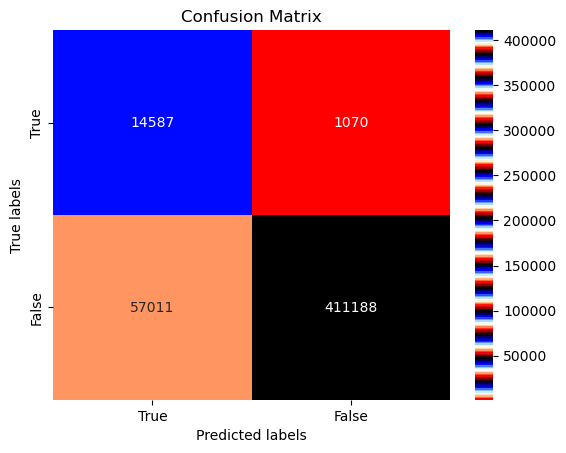

In [29]:
%%time
algo = over_sampling.BorderlineSMOTE(random_state=0)
print('Original dataset shape %s' % Counter(y_train.values.flatten().tolist()))
X_blsmote, y_blsmote = algo.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_resampled.values.flatten().tolist()))

#classificator 
sgd_clf = SGDClassifier(loss="log", n_jobs = -1) 
sgd_clf.fit(X_blsmote, y_blsmote)
sgd_pred = sgd_clf.predict(X_test)

# get scores
sgd_res = scorer(y_test, sgd_pred, 'sgd', 5)

Original dataset shape Counter({0: 1872795, 1: 62627})
Resampled dataset shape Counter({0: 1872795, 1: 1865214})
Accuracy is 0.8707
f1_score is 0.3192
precision_score is 0.9372
recall_score is 0.1924
roc_auc_score is 0.9028
HSS is 0.2806
ETS is 0.1632
CSI is 0.1899
sedi is 0.5817
CPU times: user 18 s, sys: 104 ms, total: 18.1 s
Wall time: 18.1 s


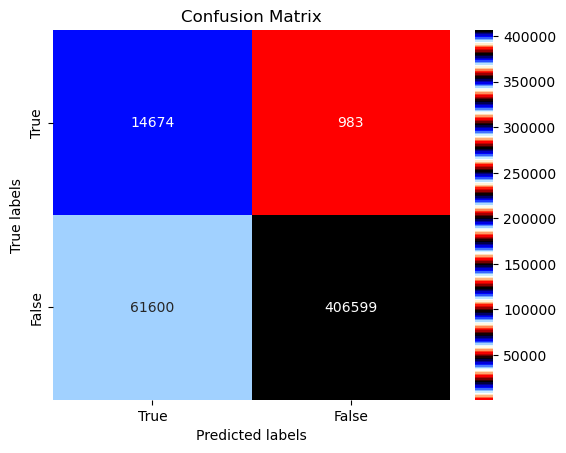

In [30]:
%%time
algo = over_sampling.ADASYN(random_state=0)
print('Original dataset shape %s' % Counter(y_train.values.flatten().tolist()))
X_resampled, y_resampled = algo.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_resampled.values.flatten().tolist()))

#classificator 
sgd_clf = SGDClassifier(loss="log", n_jobs = -1) 
sgd_clf.fit(X_resampled, y_resampled)
sgd_pred = sgd_clf.predict(X_test)

# get scores
sgd_res = scorer(y_test, sgd_pred, 'sgd', 5)

In [31]:
from imblearn import combine

Original dataset shape Counter({0: 1872795, 1: 62627})
Resampled dataset shape Counter({0: 1872047, 1: 1872047})
Accuracy is 0.9048
f1_score is 0.3822
precision_score is 0.9106
recall_score is 0.2419
roc_auc_score is 0.9076
HSS is 0.3489
ETS is 0.2113
CSI is 0.2363
sedi is 0.6163
CPU times: user 47min 53s, sys: 1.17 s, total: 47min 55s
Wall time: 8min 14s


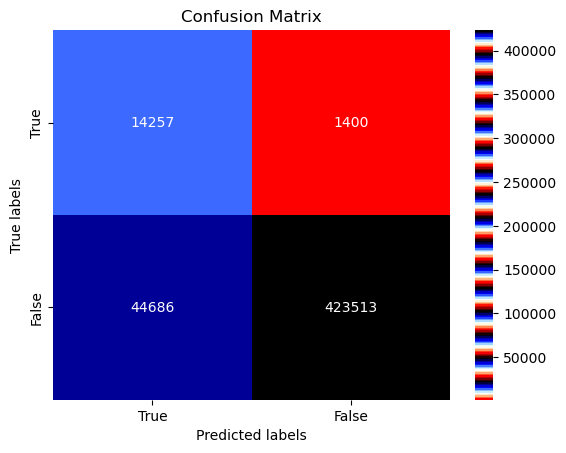

In [32]:
%%time
algo = combine.SMOTETomek(random_state=0, n_jobs=-2)
print('Original dataset shape %s' % Counter(y_train.values.flatten().tolist()))
X_resampled, y_resampled = algo.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_resampled.values.flatten().tolist()))

#classificator 
sgd_clf = SGDClassifier(loss="log", n_jobs = -1) 
sgd_clf.fit(X_resampled, y_resampled)
sgd_pred = sgd_clf.predict(X_test)

# get scores
sgd_res = scorer(y_test, sgd_pred, 'sgd', 5)

In [4]:
from sympy import *
x, y, z = symbols('x y z')

In [14]:
simplify((-0.6401840681592723-6.03001547e+03)/4.47742335e+06*x)

-0.00134690315894926*x

In [ ]:
from sympy import *
x, y, z = symbols('x y z')

In [ ]:
simplify((-0.6401840681592723-6.03001547e+03)/4.47742335e+06*x)

-0.00134690315894926*x

In [19]:
def convert_json_to_df_blitz(path, lat_max, lat_min, lon_max, lon_min):
    """Convert blitzortung data from json to pd.Dataframe with given borders"""
    if os.path.exists(Paths.interim + 'df_blitz.parquet'):
        print("Blitzortung data is already converted")
        return pd.read_parquet(Paths.interim + 'df_blitz.parquet')
    else:
        blitz_files = onlyfiles(path)

        Time = []
        Lat = []
        Lon = []
        whatever = []

        for jsonfilename in tqdm(blitz_files):
            with gzip.open(jsonfilename, 'r') as fin:
                json_bytes = fin.read()
            splitted = json_bytes.split(b'\n')

            for i in range(len(splitted)):
                try:
                    pime = (datetime.fromtimestamp(
                        mktime(time.gmtime((float(splitted[i][8:27]) * 10**-9)))))
                    pat = (float(splitted[i][34:42]))
                    pon = (float(splitted[i][50:58]))
                    whatever.append((pime, pat, pon))

                except ValueError as e:
                    if str(e) == "could not convert string to float: ''":
                        pass

        print(f'Number of blitzortung cases is: {len(whatever)}')
        df = pd.DataFrame(np.array(whatever), columns=['date', 'lat', 'lon'])
        df['lat'] = pd.to_numeric(df['lat'])
        df['lon'] = pd.to_numeric(df['lon'])
        df['date'] = df['date'].dt.ceil(freq='10min')
        df['Lightning'] = 1
        df_drop = df[(df.lat < lat_max) & (df.lat > lat_min) &
                     (df.lon < lon_max) & (df.lon > lon_min)]
        df_final = df_drop.sort_values('date').reset_index(drop=True)
        df_final.to_parquet(Paths.interim + 'df_blitz.parquet')
        return df_final

In [21]:
df_final = pd.read_parquet(Paths.interim + 'df_blitz.parquet')
df_final

,date,lat,lon,Lightning
0,2020-01-04 07:30:00,59.40169,26.93418,1
1,2020-01-04 07:30:00,59.40454,26.92817,1
2,2020-01-04 07:30:00,59.40583,26.92813,1
3,2020-01-04 07:30:00,59.39879,26.93298,1
4,2020-04-02 22:10:00,60.27147,26.63315,1
...,...,...,...,...
125419,2022-06-29 17:00:00,58.40788,27.86428,1
125420,2022-06-29 17:00:00,58.28907,27.95999,1
125421,2022-06-29 17:00:00,58.36026,27.85384,1
125422,2022-06-29 17:00:00,58.41312,27.80046,1


In [4]:
import pandas as pd
from DWR_preprocess import *

In [17]:
whatever = []
for i in range(len(splitted)):
    try:
        pime = (datetime.fromtimestamp(
            mktime(time.gmtime((float(splitted[i][8:27]) * 10**-9)))))
        pat = (float(splitted[i][34:42]))
        pon = (float(splitted[i][50:58]))
        whatever.append((pime, pat, pon))
    except ValueError as e:
        if str(e) == "could not convert string to float: ''":
            pass

In [18]:
whatever

[(datetime.datetime(2022, 6, 29, 13, 20, 2), 52.60258, 29.40545),
 (datetime.datetime(2022, 6, 29, 13, 20, 2), 52.59961, 29.4946),
 (datetime.datetime(2022, 6, 29, 13, 20, 2), 61.74014, 21.27884),
 (datetime.datetime(2022, 6, 29, 13, 20, 2), 61.76308, 21.11216),
 (datetime.datetime(2022, 6, 29, 13, 20, 2), 61.73007, 21.20696),
 (datetime.datetime(2022, 6, 29, 13, 20, 9), 26.30118, -79.0963),
 (datetime.datetime(2022, 6, 29, 13, 20, 9), 26.24161, -79.0956),
 (datetime.datetime(2022, 6, 29, 13, 20, 9), 52.73744, 31.97344),
 (datetime.datetime(2022, 6, 29, 13, 20, 9), 52.75718, 31.88595),
 (datetime.datetime(2022, 6, 29, 13, 20, 9), 52.76106, 31.89898),
 (datetime.datetime(2022, 6, 29, 13, 20, 9), 52.76679, 31.87032),
 (datetime.datetime(2022, 6, 29, 13, 20, 17), 52.60261, 31.95831),
 (datetime.datetime(2022, 6, 29, 13, 20, 17), 52.59628, 31.96673),
 (datetime.datetime(2022, 6, 29, 13, 20, 17), 50.83417, 30.35694),
 (datetime.datetime(2022, 6, 29, 13, 20, 17), 50.81872, 30.41688),
 (datet

In [ ]:
for jsonfilename in tqdm(Paths.lightning)

In [3]:
station_number=26061

In [74]:
df = true_data_filter(Paths.interim + f'{station_number}_Convective_cloud_windows_data.parquet',station_number)

Before: 0 - (2341063,), 1 - (78689,)
After:  0 - (2225526,), 1 - (68119,)


In [75]:
df.columns

Index(['R(0,0,1)', 'R(0,0,2)', 'R(0,0,3)', 'R(0,0,4)', 'R(0,0,5)', 'R(0,0,6)',
       'R(0,0,7)', 'R(0,0,8)', 'R(0,0,9)', 'R(0,0,10)',
       ...
       'Zmax_layer_4', 'Zmax_layer_5', 'Zmax_layer_6', 'Zmax_layer_7',
       'Zmax_layer_8', 'Zmax_layer_9', 'Zmax_layer_10', 'Zmax_layer_11',
       'y_param', 'H_Zmax'],
      dtype='object', length=322)

In [76]:
df_filter = df.filter(regex='max|target|param|delta')
df_filter.columns

Index(['target', 'Hmax', 'Zmax', 'delta_iso22', 'Zmax_layer_1', 'Zmax_layer_2',
       'Zmax_layer_3', 'Zmax_layer_4', 'Zmax_layer_5', 'Zmax_layer_6',
       'Zmax_layer_7', 'Zmax_layer_8', 'Zmax_layer_9', 'Zmax_layer_10',
       'Zmax_layer_11', 'y_param', 'H_Zmax'],
      dtype='object')

In [77]:
X = df_filter.loc[:, df_filter.columns != 'target']
y = df_filter.loc[:, 'target']
#y = np.where(y>=1,1,0)
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, shuffle=True, random_state=42)

In [78]:
scaler.mean_[feature_indices_0] , scaler.var_[feature_indices_0]

(array([ 5.98662914e+03,  1.78991575e+01,  3.14036697e+00, -2.06321075e+02,
         1.36515097e+01, -2.33044556e+01, -4.81705255e+01, -7.04111569e+01,
        -8.30101943e+01, -8.93225769e+01]),
 array([4.33835841e+06, 1.09650570e+02, 2.97509535e+00, 3.76658406e+06,
        9.69965597e+01, 2.84090042e+03, 3.19889549e+03, 2.53062474e+03,
        1.70629585e+03, 1.15425153e+03]))

Accuracy is 0.9792
f1_score is 0.5978
precision_score is 0.5198
recall_score is 0.7033
roc_auc_score is 0.7565
HSS is 0.5874
ETS is 0.4158
CSI is 0.4263
sedi is 0.8738
CPU times: user 3.84 s, sys: 136 µs, total: 3.84 s
Wall time: 3.84 s


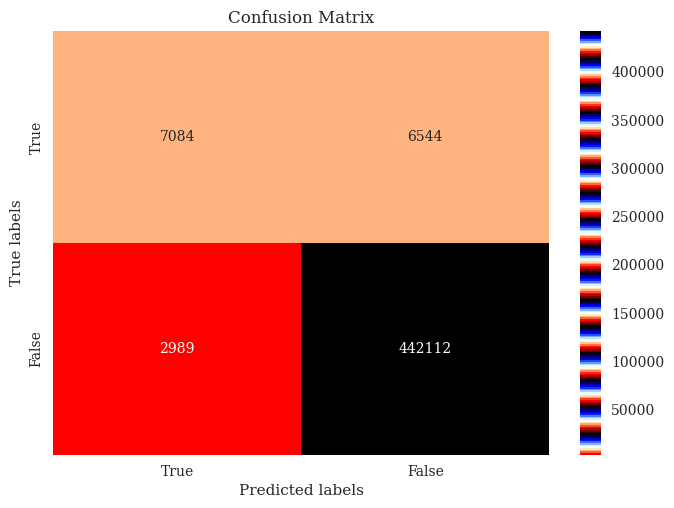

In [79]:
%%time
#classificator 
sgd = SGDClassifier(loss="log_loss", n_jobs = -1, random_state=42) 
sgd.fit(X_train, y_train)
sgd_pred = sgd.predict(X_test)


# get scores
sgd_res = scorer(y_test, sgd_pred)

In [80]:
sgd.coef_, sgd.intercept_

(array([[-5.80936841e-01,  8.57555272e-01,  1.35922482e+00,
          6.46501756e-02, -8.17549572e-02, -1.67375400e-02,
         -8.98147961e-04,  1.40707600e-01,  4.42868867e-01,
          4.72249232e-01,  3.36140488e-01,  2.15639424e-01,
          6.48019075e-02,  9.50332129e-02, -1.52231040e-01,
          2.37332217e-01]]),
 array([-6.60784438]))

Text(0.5, 0, 'Linear Regression Coef')

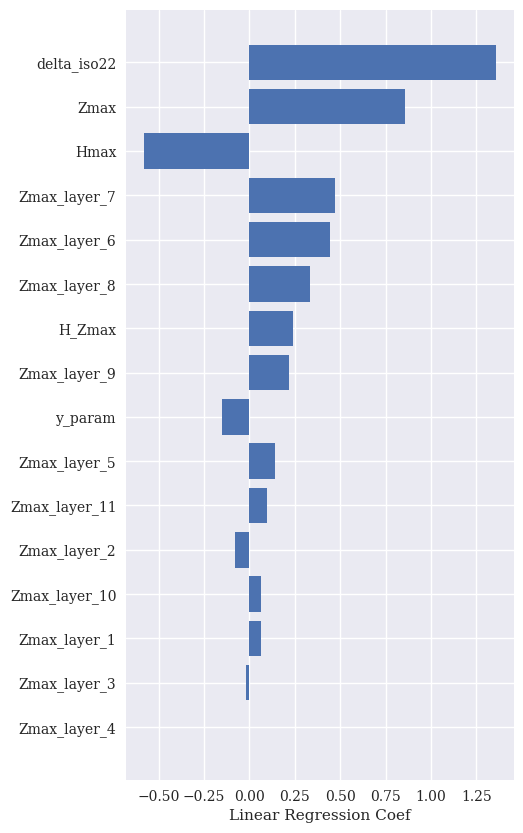

In [81]:
plt.figure(figsize=(5,10))
sorted_idx = np.abs(sgd.coef_).reshape(16).argsort()
plt.barh(X.columns[sorted_idx], sgd.coef_.reshape(16)[sorted_idx])
plt.xlabel("Linear Regression Coef")

Accuracy is 0.9824
f1_score is 0.6738
precision_score is 0.6112
recall_score is 0.7506
roc_auc_score is 0.8025
HSS is 0.6648
ETS is 0.4979
CSI is 0.508
sedi is 0.9024
CPU times: user 18min 10s, sys: 3.6 s, total: 18min 13s
Wall time: 1min 44s


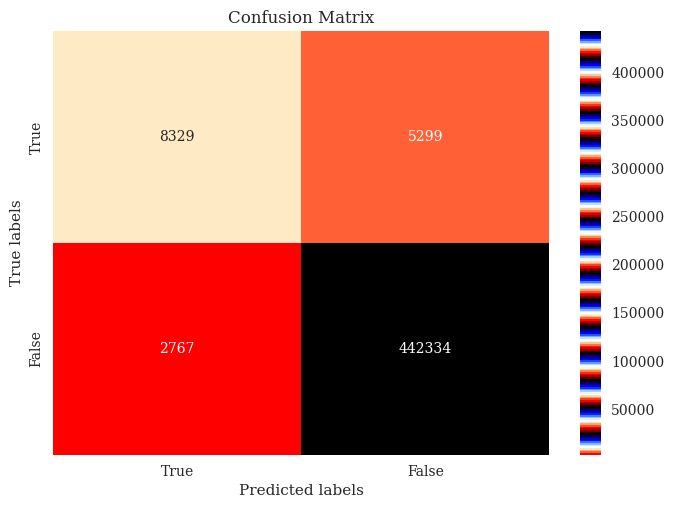

In [82]:
%%time
#classificator 
rf = RandomForestClassifier(n_jobs = -2) 
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

# get scores
rf_res = scorer(y_test, rf_pred)

Text(0.5, 0, 'Random Forest Feature Importance')

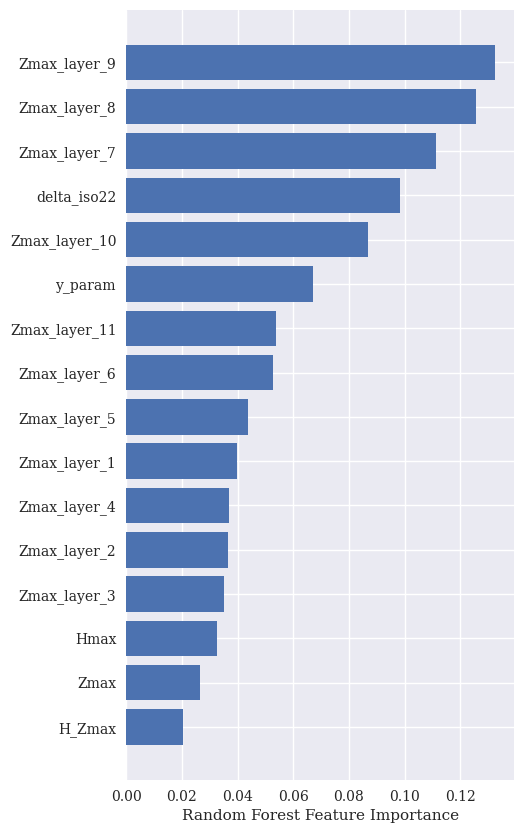

In [83]:
plt.figure(figsize=(5,10))
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [84]:
X.columns

Index(['Hmax', 'Zmax', 'delta_iso22', 'Zmax_layer_1', 'Zmax_layer_2',
       'Zmax_layer_3', 'Zmax_layer_4', 'Zmax_layer_5', 'Zmax_layer_6',
       'Zmax_layer_7', 'Zmax_layer_8', 'Zmax_layer_9', 'Zmax_layer_10',
       'Zmax_layer_11', 'y_param', 'H_Zmax'],
      dtype='object')

In [85]:
X_test_reversed = pd.DataFrame(scaler.inverse_transform(X_test), columns=X.columns)
X_test_reversed

,Hmax,Zmax,delta_iso22,Zmax_layer_1,Zmax_layer_2,Zmax_layer_3,Zmax_layer_4,Zmax_layer_5,Zmax_layer_6,Zmax_layer_7,Zmax_layer_8,Zmax_layer_9,Zmax_layer_10,Zmax_layer_11,y_param,H_Zmax
0,4500.0,22.0,383.0,21.0,22.0,22.0,18.0,7.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,1.300000e+01,2.0
1,5000.0,19.0,-898.0,16.0,16.0,18.0,19.0,16.0,12.0,-100.0,-100.0,-100.0,-100.0,-100.0,1.300000e+01,4.0
2,4250.0,7.0,-2166.0,-100.0,-100.0,-100.0,7.0,7.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,8.000000e+00,4.0
3,4250.0,33.0,-1121.0,16.0,33.0,29.0,16.0,8.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,1.100000e+01,2.0
4,4500.0,7.0,-729.0,7.0,7.0,7.0,6.0,6.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,8.000000e+00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458724,5000.0,13.0,-1357.0,-100.0,13.0,13.0,11.0,8.0,5.0,-100.0,-100.0,-100.0,-100.0,-100.0,1.000000e+01,2.0
458725,5250.0,2.0,-1041.0,-100.0,-100.0,-100.0,-100.0,2.0,2.0,-100.0,-100.0,-100.0,-100.0,-100.0,3.000000e+00,5.0
458726,10250.0,18.0,2897.0,-100.0,-100.0,6.0,14.0,15.0,16.0,18.0,16.0,16.0,11.0,8.0,2.800000e+01,7.0
458727,5000.0,19.0,594.0,16.0,19.0,19.0,16.0,10.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,1.400000e+01,2.0


In [86]:
feature_indices_0 = np.array([ 0,  1, 15,  2, 14,  8,  9, 10, 11, 12])

In [109]:
X_test_set_0 = X.iloc[:, feature_indices_0]

In [110]:
X_test_set_0

,Hmax,Zmax,H_Zmax,delta_iso22,y_param,Zmax_layer_6,Zmax_layer_7,Zmax_layer_8,Zmax_layer_9,Zmax_layer_10
12,6250,16,5,-412,17,15,12,-100,-100,-100
13,6500,18,5,-162,18,16,13,-100,-100,-100
14,5000,12,6,-1662,0,12,-100,-100,-100,-100
15,5500,15,3,-1162,14,12,-100,-100,-100,-100
16,5750,16,3,-912,15,13,-100,-100,-100,-100
...,...,...,...,...,...,...,...,...,...,...
1581019,3750,21,3,-2624,0,-100,-100,-100,-100,-100
1822684,4000,9,3,-3039,2,-100,-100,-100,-100,-100
1646560,4000,16,1,-2305,10,-100,-100,-100,-100,-100
2203618,6500,3,7,-900,4,2,3,-100,-100,-100


In [111]:
coef = [-1.4594827779422352,
  0.3038427733259509,
  -0.025024611716539403,
  1.7895984359913326,
  0.20528146861255284,
  3.607158324022024,
  0.426577777982917,
  0.31166985925677027,
  0.017550715701096165,
  0.2528106437870482]

In [112]:
inter = -6.858261682081707

In [113]:
means = np.array([ 8.33179330e+03,  2.41869337e+01,  3.35110477e+00,  1.91723360e+03,
         2.27546494e+01,  7.64304064e+00, -2.50841883e+00, -1.81673450e+01,
        -3.95604094e+01, -5.86931275e+01])
vars = np.array([6.11829165e+06, 1.91041161e+02, 3.14338962e+00, 5.12933410e+06,
        1.54771159e+02, 1.14374303e+03, 1.74410089e+03, 2.56571620e+03,
        3.14130236e+03, 2.95329772e+03])

Accuracy is 0.9754
f1_score is 0.3465
precision_score is 0.22
recall_score is 0.8165
roc_auc_score is 0.6092
HSS is 0.3382
ETS is 0.2035
CSI is 0.2096
sedi is 0.9203


0    0.975365
1    0.346548
2    0.219953
3    0.816468
4    0.609220
5    0.338206
6    0.203518
7    0.209591
8    0.920265
dtype: float64

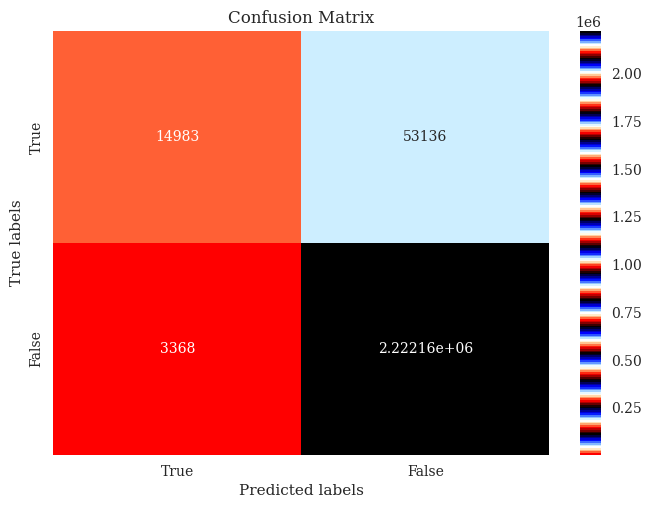

In [115]:
scaled_df = (np.subtract(X_test_set_0,means))/np.sqrt(vars)
dot_prod = np.dot(scaled_df, coef)+inter
res_preds_0 = np.where(dot_prod >= 0, 1,0)
scorer(y, res_preds_0)

Accuracy is 0.9703
f1_score is nan
precision_score is 0.0
recall_score is nan
roc_auc_score is 0.5
HSS is 0.0
ETS is 0.0
CSI is 0.0
sedi is nan


0    0.970292
1         NaN
2    0.000000
3         NaN
4    0.500000
5    0.000000
6    0.000000
7    0.000000
8         NaN
dtype: float64

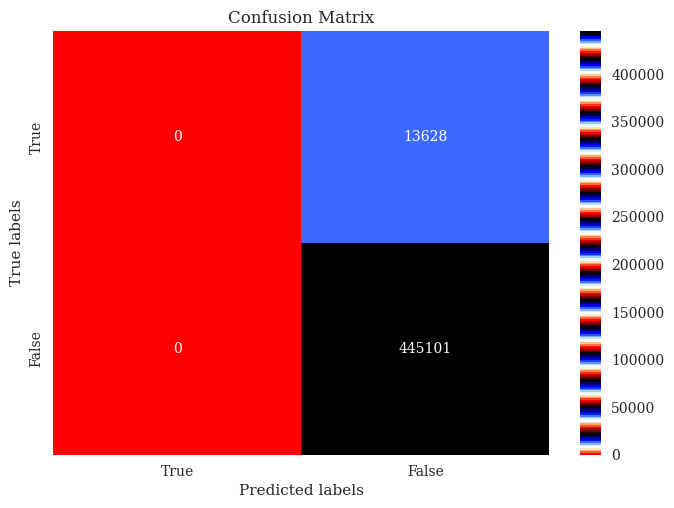

In [102]:
scorer(y_test, preds)

In [95]:
features_set_0 = ['Hmax', 'Zmax', 'H_Zmax', 'delta_iso22', 'y_param','Zmax_layer_6', 'Zmax_layer_7', 'Zmax_layer_8',
       'Zmax_layer_9', 'Zmax_layer_10']

In [96]:
feature_indices_0 = []
for feature in features_set_0:
    feature_indices_0.append(np.argwhere(np.array(X.columns) == feature))
feature_indices_0 = np.array(feature_indices_0).reshape(np.array(feature_indices_0).shape[0])
feature_indices_0


array([ 0,  1, 15,  2, 14,  8,  9, 10, 11, 12])

In [106]:
X

,Hmax,Zmax,delta_iso22,Zmax_layer_1,Zmax_layer_2,Zmax_layer_3,Zmax_layer_4,Zmax_layer_5,Zmax_layer_6,Zmax_layer_7,Zmax_layer_8,Zmax_layer_9,Zmax_layer_10,Zmax_layer_11,y_param,H_Zmax
12,6250,16,-412,-100,14,14,15,16,15,12,-100,-100,-100,-100,17,5
13,6500,18,-162,-100,-100,14,15,18,16,13,-100,-100,-100,-100,18,5
14,5000,12,-1662,-100,-100,-100,-100,-100,12,-100,-100,-100,-100,-100,0,6
15,5500,15,-1162,-100,-100,15,15,14,12,-100,-100,-100,-100,-100,14,3
16,5750,16,-912,-100,-100,16,16,15,13,-100,-100,-100,-100,-100,15,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1581019,3750,21,-2624,9,14,21,14,-100,-100,-100,-100,-100,-100,-100,0,3
1822684,4000,9,-3039,3,6,9,8,2,-100,-100,-100,-100,-100,-100,2,3
1646560,4000,16,-2305,16,16,16,16,14,-100,-100,-100,-100,-100,-100,10,1
2203618,6500,3,-900,-100,-100,-100,-100,2,2,3,-100,-100,-100,-100,4,7


In [108]:
X_train_set_0 = X_train[:, feature_indices_0]
X_test_set_0 = X_test[:, feature_indices_0]

Accuracy is 0.9791
f1_score is 0.5789
precision_score is 0.484
recall_score is 0.7199
roc_auc_score is 0.7391
HSS is 0.5685
ETS is 0.3972
CSI is 0.4073
sedi is 0.8807
CPU times: user 14 s, sys: 20.1 ms, total: 14 s
Wall time: 14 s


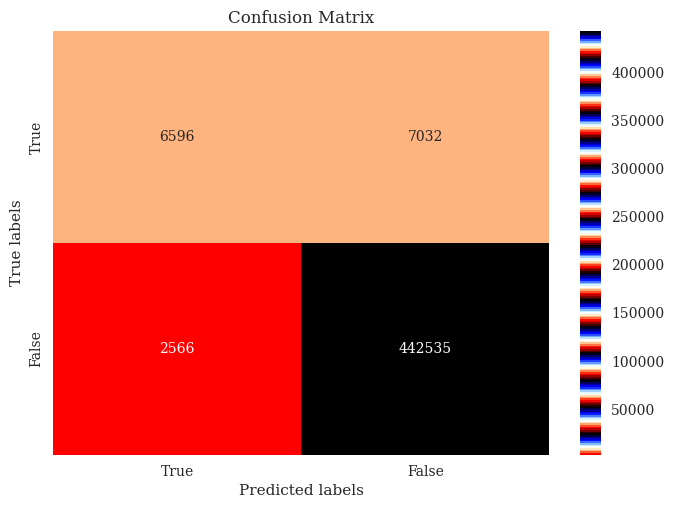

In [98]:
%%time
#classificator 
sgd = LogisticRegression(solver="saga", n_jobs = -1, random_state=42) 
sgd.fit(X_train_set_0, y_train)
sgd_pred_0 = sgd.predict(X_test_set_0)


# get scores
sgd_res = scorer(y_test, sgd_pred_0)

In [99]:
coef_set_0 = sgd.coef_.tolist()[0]
inter_set_0 = sgd.intercept_.tolist()[0]
coef_set_0, inter_set_0

([-0.639243663937659,
  0.8551190949277104,
  0.245417349603466,
  1.5591457486408773,
  -0.12700607806288347,
  0.5169288478384069,
  0.4678676340456219,
  0.2950420877671173,
  0.18817580602393275,
  0.09371182694775773],
 -6.725828009609889)